In [1]:
import sys

sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRG_MPI/thumair_jpsiks/pythonTools")
sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRD_MPI/Lib_Xgboost/xgboost/python-package")
!{sys.executable} -m pip install iminuit==2.2.1

%env TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.
env: TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rootTools as tap
#import rootTools as tap

Welcome to JupyROOT 6.20/04


In [3]:
fName = '/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/datafortres.csv'
#tupleDir = "/pnfs/desy.de/belle/local/user/jkandra/MC13-04/B0toJPsiKStoEE/"
tupleDir = "/nfs/dust/belle2/user/jkandra/MC13-04/B0toJPsiKStoEE/"

In [4]:
import noteBookTools as nbt
totDicts = nbt.getDictForBDT()
listVars = [totDict['var'] for totDict in totDicts] + ['KFold', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr', 'MCDeltaT', 'DeltaT']
listFormulas = [totDict['form'] for totDict in totDicts] + ['__event__ % 2', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr','MCDeltaT', 'DeltaT']

totDictKins = nbt.getDictForBToDPi("B0toJPsiKStoEE")
listVarKins = [totDictKin['var'] for totDictKin in totDictKins]
listFormulaKins = [totDictKin['form'] for totDictKin in totDictKins]

In [5]:
#from root_pandas import read_root
#Data = read_root(tupleDir+"B0toJPsiKStoEE.root", "B0ToJPsi_eeKS_pipi")
Data = tap.getPandaFromFiles(fileNames=[tupleDir+"B0toJPsiKStoEE.root"],
                               listVarFormulas=listFormulas + listFormulaKins,
                               listVarNames=listVars + listVarKins, 
                               treeName="B0ToJPsi_eeKS_pipi", cut="isSignal")

.......... 


362258
362258
[-0.39020038  0.09818757 -0.49523634 ... -1.64740801 -0.89777794
 -0.4567161 ]
quantile - rozdiel 0.4638914322853088
quantile 0.1772138071060181
mu -0.12934180675074458


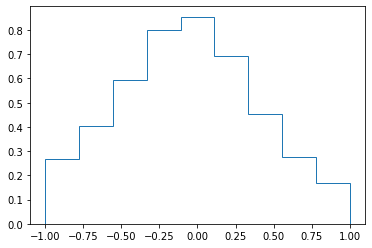

In [6]:
vDatamc = Data["MCDeltaT"].to_numpy()
vData = Data["DeltaT"].to_numpy()
vDataRes = np.subtract(vData,vDatamc)


print(vData.size)
vData = vData[~np.isnan(vData)]
print(vData.size)


plt.hist(vDataRes, histtype='step', density = True, bins=np.linspace(-1, 1, 10))
print(vDataRes)

#Estimation of the s, mu parameters 
a = 0.25*(np.quantile(vDataRes,q=0.84) - np.quantile(vDataRes,q=0.16 ))
print('quantile - rozdiel',a)
c = np.quantile(vDataRes, q=0.68)
print('quantile',c)
b = np.quantile(vDataRes,q=0.5)
print('mu', b)


In [7]:
def gausInt(a, b, c, d):
     m = d / c
     s = 1./np.sqrt(c)
     from math import erf
     res = np.sqrt(np.pi)/(2*np.sqrt(c)) * (erf((b*c-d)/np.sqrt(c)) - erf((a*c-d)/np.sqrt(c)))
     
     return res

def convExpGaus(sK, tau, x):
     c = 1./(2*sK*sK)
     d = 0.5*(x/sK/sK - 1/tau)
     Const = 1./(np.sqrt(2*np.pi) *sK* tau) * np.exp(-1./2 * pow(x/sK,2) + d*d/c)
     return Const * gausInt(0, 1e15, c, d);
  
def Gauss(x, mean, sigma):
    f = 1./(np.sqrt(2*np.pi)*sigma) * np.exp( -1./2 * pow((x-mean)/sigma, 2))
    return f

def fun(x, pars):
    fTMains = pars["fTMains"]
    fTR     = pars["fTR"]
    sigmas  = pars["sigmas"]
    cLMs    = pars["cLMs"]
    cRMs    = pars["cRMs"]
    mus     = pars["mus"]
    
    bigSigmaFrac = pars['bigSigmaFrac']
    fTBigs = pars['fTBigs']
    bigSigmaScale = pars['bigSigmaScale']
    cLBs = pars['cLBs']
    cRBs = pars['cRBs']
    
    ret = 0
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains) * Gauss(x, mean=mus, sigma=sigmas)
    ret += (1-bigSigmaFrac) * fTMains*(1.-fTR)*convExpGaus(sigmas, 1./cLMs, mus - x)
    ret += (1-bigSigmaFrac) * fTMains*(fTR)*convExpGaus(sigmas, 1./cRMs,  x - mus )
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs) * Gauss(x, mean=mus, sigma=bigSigmaScale*sigmas)
    ret += bigSigmaFrac * fTBigs*(1.-fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cLBs, mus - x)
    ret += bigSigmaFrac * fTBigs*(fTR)*convExpGaus(bigSigmaScale*sigmas, 1./cRBs,  x - mus )
    
    return ret




In [36]:
import chebFitter as chf
xLim = 35
ch = chf.chebFitter(516 + 1, -xLim, xLim, vDataRes, fun)
#pars = {"mus" : 0, "sigmas" : 30,  "fTMains" : 0.9, "fTR" : 0.5, "fTBigs":0.1, "cLMs" : 0.1, "cRMs" : 0.1, "cLBs":0.1, "cRBs":0.1, "bigSigmaScale":5, "bigSigmaFrac":0.1 }


pars = {'mus': -0.04741069244450154, 'sigmas': 0.3669683292811087, 
        'fTMains': 0.44317476615201085, 'fTR': 0.3320483201069004, 
        'fTBigs': 0.15798670990300853, 'cLMs': 0.6216726025457053, 
        'cRMs': 0.5073563502345398, 'cLBs': 0.11178432858860217, 
        'cRBs': 0.07043895091906388, 'bigSigmaScale': 2.2164804658432167,
        'bigSigmaFrac': 0.32603235931359464}

#pars = res
Limits = { 
        'mus': (-10, 10),
        'sigmas': (10, 40),
        'fTMains': (0, 1),
        'fTR': (0, 1),
        'cLMs': (1e-5, 0.1),
        'cRMs': (1e-5, 0.1),
         "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        'fTBigs' : (0,1),
        'cLBs' : (1e-5, 0.05),
        'cRBs' : (1e-5, 0.05)
        }

res =  ch.fitData(pars)
print(res)


Loading data grid
Done
{'mus': -0.04741069244450154, 'sigmas': 0.3669683292811087, 'fTMains': 0.44317476615201085, 'fTR': 0.3320483201069004, 'fTBigs': 0.15798670990300853, 'cLMs': 0.6216726025457053, 'cRMs': 0.5073563502345398, 'cLBs': 0.11178432858860217, 'cRBs': 0.07043895091906388, 'bigSigmaScale': 2.2164804658432167, 'bigSigmaFrac': 0.32603235931359464}


In [28]:
def plotHist(d, bins, chFit, res):
    vals, bins = np.histogram(d, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    x = np.linspace(bins[0], bins[-1], 500)
    y = N * chFit.funFast(x, res)
    
    axs[0].plot(x, y, label ='B0toJPsiKStoEE')
    axs[0].legend(loc='upper right', shadow=True, fontsize='x-large')
    # plotRatio
    yRat= N * chFit.funFast(xCnt, res) 
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")

    dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
    fig.savefig(dirName+"B0toJPsiKStoEE_Dt.png", bbox_inches='tight')


    

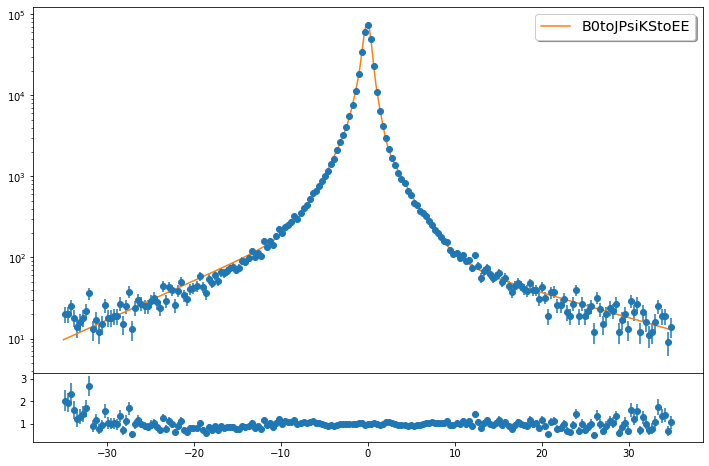

In [25]:
plotHist(vDataRes, np.linspace(-xLim, xLim, 200), ch, res)
